## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
sns.set_style('white')

## Synthetic Heatmap Generator

In [2]:
def generate_range_doppler(num_range=64, num_doppler=64, noise_level=0.02, targets=None):
    hm = np.random.randn(num_range, num_doppler) * noise_level
    if targets:
        for t in targets:  # (r,d,amp,rw,dw)
            r,d,amp,rw,dw = t
            rg = np.exp(-0.5 * ((np.arange(num_range)-r)/rw)**2)[:,None]
            dg = np.exp(-0.5 * ((np.arange(num_doppler)-d)/dw)**2)[None,:]
            hm += amp * rg * dg
    hm = np.clip(hm,0,None)
    hm /= (hm.max()+1e-9)
    return hm

## Dataset Synthesis (>=300 Samples)

In [3]:
import os
os.makedirs('data', exist_ok=True)
np.random.seed(42)
num_samples = 400
images = []
labels = []

for i in range(num_samples):
    if i % 2 == 0:  # metal
        r = np.random.randint(15,50)
        d = np.random.randint(15,50)
        # Variable metal signature (some weak, some strong)
        if np.random.rand() < 0.3:  # 30% weak metal (challenging)
            amp = np.random.uniform(1.5,2.5)
            metal_width = np.random.uniform(2.5,3.5)
        else:
            amp = np.random.uniform(2.8,5.0)
            metal_width = np.random.uniform(1.8,2.8)
        
        # Realistic clutter near metal (makes it harder)
        clutter = []
        num_clutter = np.random.randint(1,4)
        for _ in range(num_clutter):
            rc = np.random.randint(5,59)
            dc = np.random.randint(5,59)
            # Some clutter intentionally near metal
            if np.random.rand() < 0.4 and abs(rc-r)>5:
                rc = r + np.random.randint(-15,15)
                dc = d + np.random.randint(-15,15)
                rc = np.clip(rc, 5, 58)
                dc = np.clip(dc, 5, 58)
            amp_c = np.random.uniform(0.4,1.8)
            clutter.append((rc,dc,amp_c,np.random.uniform(3,7),np.random.uniform(3,7)))
        
        targets = [(r,d,amp,metal_width,metal_width)] + clutter
        hm = generate_range_doppler(num_range=64, num_doppler=64, 
                                     noise_level=np.random.uniform(0.04,0.12), 
                                     targets=targets)
        label = 1
    else:  # non-metal
        clutter_count = np.random.randint(2,6)
        targets = []
        # Some strong non-metal returns (confusers)
        has_strong = np.random.rand() < 0.3
        for j in range(clutter_count):
            r = np.random.randint(5,59)
            d = np.random.randint(5,59)
            if j == 0 and has_strong:  # One strong clutter peak
                amp = np.random.uniform(2.0,3.5)
                rw = np.random.uniform(2.5,4.0)
                dw = np.random.uniform(2.5,4.0)
            else:
                amp = np.random.uniform(0.5,2.2)
                rw = np.random.uniform(3,8)
                dw = np.random.uniform(3,8)
            targets.append((r,d,amp,rw,dw))
        
        hm = generate_range_doppler(num_range=64, num_doppler=64,
                                     noise_level=np.random.uniform(0.04,0.12),
                                     targets=targets)
        label = 0
    
    # Range-dependent attenuation
    range_atten = np.linspace(1.0, 0.65, 64)[:, None]
    hm = hm * range_atten
    
    # Random fade/multipath effect
    if np.random.rand() < 0.2:
        fade = 0.7 + 0.3*np.random.rand()
        hm = hm * fade
    
    images.append(hm)
    labels.append(label)

images = np.stack(images).astype(np.float32)
labels = np.array(labels).astype(np.int64)

# Augmentation: noise and intensity variations
augmented_images = [images]
augmented_labels = [labels]

for img, lbl in zip(images[:100], labels[:100]):  # Augment 25%
    # Noise injection
    noisy = img + np.random.randn(64,64)*0.08
    noisy = np.clip(noisy, 0, None)
    noisy = noisy / (noisy.max() + 1e-9)
    augmented_images.append(noisy[None,...])
    augmented_labels.append(np.array([lbl]))

images = np.concatenate(augmented_images).astype(np.float32)
labels = np.concatenate(augmented_labels).astype(np.int64)

np.savez('data/dataset.npz', images=images, labels=labels)
print(f'Dataset created: {len(images)} samples ({np.sum(labels==1)} metal, {np.sum(labels==0)} non-metal)')
images.shape, labels.shape

Dataset created: 500 samples (250 metal, 250 non-metal)


((500, 64, 64), (500,))

## Dataset & DataLoader

In [4]:
class HeatmapDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        x = self.images[idx][None, ...]  # add channel dim
        return torch.from_numpy(x), torch.tensor(self.labels[idx])
# Train / Val split
perm = np.random.permutation(len(images))
train_size = int(0.8 * len(images))
train_idx, val_idx = perm[:train_size], perm[train_size:]
train_ds = HeatmapDataset(images[train_idx], labels[train_idx])
val_ds = HeatmapDataset(images[val_idx], labels[val_idx])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

## CNN Model

In [5]:
class MetalClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout2d(dropout),
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Dropout2d(dropout),
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32,2)
        )
    def forward(self,x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
model = MetalClassifier(dropout=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

Using device: cpu


## Training Loop

Epoch  2: train_loss=0.6333 train_acc=0.708 val_acc=0.450


Epoch  4: train_loss=0.5786 train_acc=0.765 val_acc=0.860


Epoch  6: train_loss=0.5501 train_acc=0.750 val_acc=0.890


Epoch  8: train_loss=0.4950 train_acc=0.760 val_acc=0.890


Epoch 10: train_loss=0.5083 train_acc=0.772 val_acc=0.870


Epoch 12: train_loss=0.4712 train_acc=0.775 val_acc=0.880


Epoch 14: train_loss=0.4699 train_acc=0.802 val_acc=0.880


Epoch 16: train_loss=0.5020 train_acc=0.750 val_acc=0.880


Epoch 18: train_loss=0.4587 train_acc=0.800 val_acc=0.880


Epoch 20: train_loss=0.4758 train_acc=0.775 val_acc=0.880


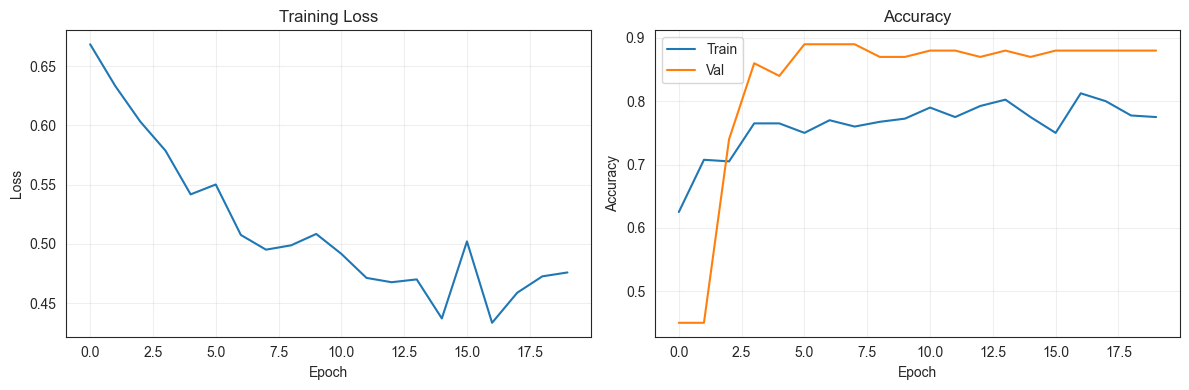


Final: train_acc=0.775, val_acc=0.880


In [6]:
epochs = 20
history = {'train_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(epochs):
    model.train(); total_loss=0; correct=0; n=0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward(); optimizer.step()
        total_loss += loss.item()*x.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item(); n += x.size(0)
    train_acc = correct/n; train_loss = total_loss/n
    
    # Validation
    model.eval(); v_correct=0; v_n=0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            v_correct += (pred==y).sum().item(); v_n += x.size(0)
    val_acc = v_correct/v_n
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch {epoch+1:2d}: train_loss={train_loss:.4f} train_acc={train_acc:.3f} val_acc={val_acc:.3f}')

# Plot training curves
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(history['train_loss'])
ax1.set_title('Training Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.grid(alpha=0.3)
ax2.plot(history['train_acc'], label='Train')
ax2.plot(history['val_acc'], label='Val')
ax2.set_title('Accuracy'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.legend(); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()
print(f'\nFinal: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}')

## Evaluation: Confusion Matrix

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
model.eval(); all_preds=[]; all_labels=[]
with torch.no_grad():
    for x,y in val_loader:
        o = model(x.to(device))
        p = o.argmax(1).cpu().numpy()
        all_preds.append(p)
        all_labels.append(y.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', cm)
print(classification_report(all_labels, all_preds, target_names=['non-metal','metal']))

Confusion Matrix:
 [[46  9]
 [ 3 42]]
              precision    recall  f1-score   support

   non-metal       0.94      0.84      0.88        55
       metal       0.82      0.93      0.88        45

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



## Save Model

In [8]:
import os
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/metal_classifier.pt')
print('Model saved to models/metal_classifier.pt')

Model saved to models/metal_classifier.pt


## Single Prediction Demo

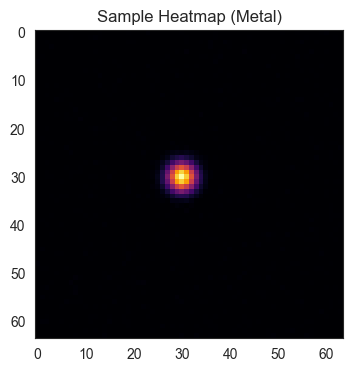

Predicted class: metal


In [9]:
sample = generate_range_doppler(targets=[(30,30,5.0,2,2)])
plt.figure(figsize=(4,4))
plt.imshow(sample, cmap='inferno')
plt.title('Sample Heatmap (Metal)')
plt.show()
x = torch.from_numpy(sample[None,None,...].astype(np.float32))
with torch.no_grad():
    pred = model(x.to(device)).argmax(1).item()
print('Predicted class:', 'metal' if pred==1 else 'non-metal')

### Summary
A CNN was trained on synthetic heatmaps to classify metal vs non-metal. Results include accuracy, confusion matrix, and example predictions.

In [10]:
# SVM + PCA Baseline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Flatten images for PCA
flat_train = images[train_idx].reshape(len(train_idx), -1)
flat_val = images[val_idx].reshape(len(val_idx), -1)

# Reduce dimensionality
pca = PCA(n_components=50, random_state=42)
flat_train_red = pca.fit_transform(flat_train)
flat_val_red = pca.transform(flat_val)

svm = SVC(kernel='rbf', C=2.0, gamma='scale')
svm.fit(flat_train_red, labels[train_idx])
svm_preds = svm.predict(flat_val_red)
svm_acc = accuracy_score(labels[val_idx], svm_preds)
print(f'SVM Baseline Accuracy: {svm_acc:.3f}')

SVM Baseline Accuracy: 0.910
